In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import metrics
from sklearn.utils import class_weight

In [13]:
!unzip "/content/drive/My Drive/Dataset_original.zip" -d "/content"

Archive:  /content/drive/My Drive/Dataset_original.zip
   creating: /content/Dataset/Mild/
  inflating: /content/Dataset/Mild/0024cdab0c1e.png  
  inflating: /content/Dataset/Mild/00cb6555d108.png  
  inflating: /content/Dataset/Mild/0124dffecf29.png  
  inflating: /content/Dataset/Mild/01b3aed3ed4c.png  
  inflating: /content/Dataset/Mild/0369f3efe69b.png  
  inflating: /content/Dataset/Mild/03e25101e8e8.png  
  inflating: /content/Dataset/Mild/04ac765f91a1.png  
  inflating: /content/Dataset/Mild/059bc89df7f4.png  
  inflating: /content/Dataset/Mild/05a5183c92d0.png  
  inflating: /content/Dataset/Mild/0684311afdfc.png  
  inflating: /content/Dataset/Mild/06b71823f9cd.png  
  inflating: /content/Dataset/Mild/07929d32b5b3.png  
  inflating: /content/Dataset/Mild/07a1c7073982.png  
  inflating: /content/Dataset/Mild/086d41d17da8.png  
  inflating: /content/Dataset/Mild/09935d72892b.png  
  inflating: /content/Dataset/Mild/0a3202889f4d.png  
  inflating: /content/Dataset/Mild/0a61bddab9

In [14]:
DIR = "Dataset"
IMAGE_SIZE = [224,224]
BATCH_SIZE = 32

In [4]:
gen = ImageDataGenerator(rotation_range=0,
                        preprocessing_function=preprocess_input,
                         validation_split=0.2)

In [15]:
train_generator = gen.flow_from_directory(
    DIR,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='training') # set as training data

Found 2931 images belonging to 5 classes.


In [16]:
validation_generator = gen.flow_from_directory(
    DIR, 
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation') # set as validation data

Found 731 images belonging to 5 classes.


In [17]:
vgg16 = VGG16(weights='imagenet')
vgg16.summary()

x  = vgg16.get_layer('fc2').output
prediction = Dense(5, activation='softmax', name='predictions')(x)

model = Model(inputs=vgg16.input, outputs=prediction)

553467904/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [18]:
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-16:]:
    layer.trainable = True
    print("Layer '%s' is trainable" % layer.name) 

Layer 'block3_conv1' is trainable
Layer 'block3_conv2' is trainable
Layer 'block3_conv3' is trainable
Layer 'block3_pool' is trainable
Layer 'block4_conv1' is trainable
Layer 'block4_conv2' is trainable
Layer 'block4_conv3' is trainable
Layer 'block4_pool' is trainable
Layer 'block5_conv1' is trainable
Layer 'block5_conv2' is trainable
Layer 'block5_conv3' is trainable
Layer 'block5_pool' is trainable
Layer 'flatten' is trainable
Layer 'fc1' is trainable
Layer 'fc2' is trainable
Layer 'predictions' is trainable


In [19]:
opt = Adam(lr=0.000001)
model.compile(optimizer=opt, loss=categorical_crossentropy, 
              metrics=['accuracy'])
model.summary()  

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [20]:
early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')

In [22]:
from collections import Counter
counter = Counter(train_generator.classes)
max_val = float(max(counter.values()))   
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}
class_weights

{0: 4.878378378378378,
 1: 1.805,
 2: 1.0,
 3: 6.11864406779661,
 4: 9.316129032258065}

In [24]:
hist = model.fit(train_generator, steps_per_epoch=train_generator.samples//train_generator.batch_size, 
                 validation_data=validation_generator, 
                 class_weight=class_weights, 
                 validation_steps=validation_generator.samples//validation_generator.batch_size, 
                 epochs=80,
                 callbacks=[early])

Epoch 1/80
91/91 [==============================] - 29s 315ms/step - loss: 3.3218 - accuracy: 0.5792 - val_loss: 0.9932 - val_accuracy: 0.5838
Epoch 2/80
91/91 [==============================] - 28s 306ms/step - loss: 2.5749 - accuracy: 0.6978 - val_loss: 0.8296 - val_accuracy: 0.6932
Epoch 3/80
91/91 [==============================] - 28s 312ms/step - loss: 2.2495 - accuracy: 0.7296 - val_loss: 0.8139 - val_accuracy: 0.6918
Epoch 4/80
91/91 [==============================] - 28s 305ms/step - loss: 2.0301 - accuracy: 0.7644 - val_loss: 0.7308 - val_accuracy: 0.7429
Epoch 5/80
91/91 [==============================] - 28s 307ms/step - loss: 1.7678 - accuracy: 0.7965 - val_loss: 0.6222 - val_accuracy: 0.7770
Epoch 6/80
91/91 [==============================] - 28s 309ms/step - loss: 1.5610 - accuracy: 0.8241 - val_loss: 0.6433 - val_accuracy: 0.7614
Epoch 7/80
91/91 [==============================] - 28s 307ms/step - loss: 1.3698 - accuracy: 0.8441 - val_loss: 0.7210 - val_accuracy: 0.7401

In [25]:
model.save("/content/drive/My Drive/vgg16_classWeights_98%_80%.h5")

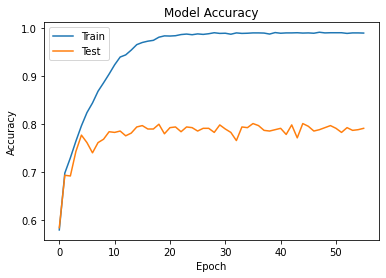

In [28]:
# summarize history for accuracy
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

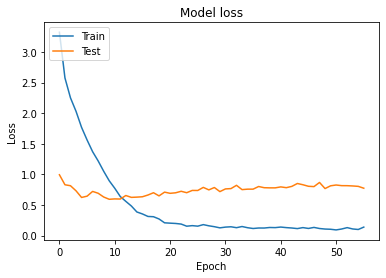

In [29]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [30]:
predictions = model.predict_generator(validation_generator, steps=33)
predicted_classes = np.argmax(predictions, axis=1)

Instructions for updating:
Please use Model.predict, which supports generators.


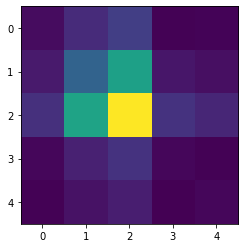

In [33]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, predicted_classes)
plt.imshow(cm)

In [ ]:
import seaborn as sns
